Begin by importing the required libraries (NOTE: make sure to pip install all libraries on powershell prompt to avoid errors)

In [1]:
from scipy import signal
from PIL import Image
import control
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import display, Math

This tutorial utilizes a free body diagram of a quarter car suspension system. In engineering, Any translational mechanical system can be defined by three elementary parts which are mass (inertia dealing with kinetic energy), spring (elasticity dealing with potential energy) and damper (gradual dissipation of energy over time). The cell below shows the diagram, derived equations & real-world values for the system

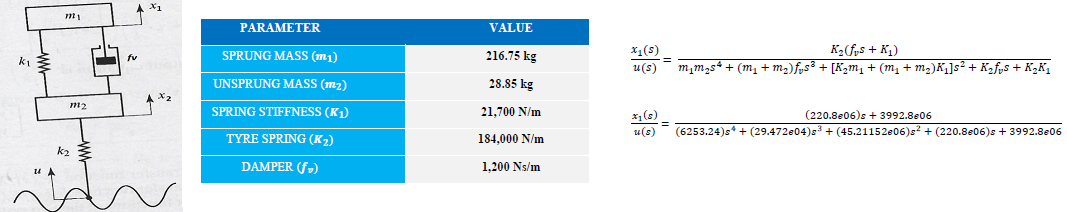

In [2]:
img = Image.open('MSD.png')
img

We start by coding the transfer function of the system in Python using both scipy and control libraries

In [3]:
# Setup the numerator and denominator coefficients of the transfer function (TF) 

num = np.array([220.8e6,3992.8e6])
den = np.array([6253.24,29.47e4,45.21e6,220.8e6,3992.8e6])

# Create the open-loop system using control library to visualize the TF model

H_op =  control.tf(num,den)

# Do the same for a closed-loop system with a unity feedback

H_cl = control.feedback(H_op)

# See the open & closed loop TF models

print('Below is the open-loop TF model of the system')
print()
print('H(s) = ', H_op)
print('Below is the closed-loop TF model of the system')
print()
print('H(s) = ', H_cl)

Below is the open-loop TF model of the system

H(s) =  
                     2.208e+08 s + 3.993e+09
------------------------------------------------------------------
6253 s^4 + 2.947e+05 s^3 + 4.521e+07 s^2 + 2.208e+08 s + 3.993e+09

Below is the closed-loop TF model of the system

H(s) =  
                     2.208e+08 s + 3.993e+09
------------------------------------------------------------------
6253 s^4 + 2.947e+05 s^3 + 4.521e+07 s^2 + 4.416e+08 s + 7.986e+09



NOTE: The above computation can also be done using scipy's signal library but visualizing the results is not user-friendly. This is shown below:

Below is the open-loop TF model of the system

H(s) =  TransferFunctionContinuous(
array([ 35309.69545388, 638516.99279094]),
array([1.00000000e+00, 4.71275691e+01, 7.22985204e+03, 3.53096955e+04,
       6.38516993e+05]),
dt: None
)
Below is the closed-loop TF model of the system

H(s) =  TransferFunctionContinuous(
array([ 35309.69545388, 638516.99279094]),
array([1.00000000e+00, 4.71275691e+01, 7.22985204e+03, 7.06193909e+04,
       1.27703399e+06]),
dt: None
)



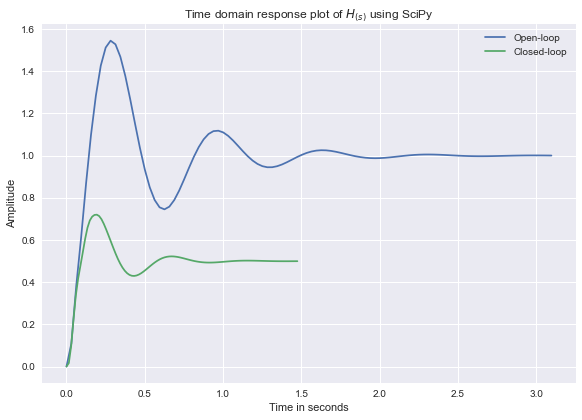

In [4]:
# Closed and open-loop TFs with scipy signal library

sys_op = signal.TransferFunction(num,den)
sys_cl = signal.TransferFunction(np.extract(H_cl.num,H_cl.num),np.extract(H_cl.den,H_cl.den))

print('Below is the open-loop TF model of the system')
print()
print('H(s) = ', sys_op)
print('Below is the closed-loop TF model of the system')
print()
print('H(s) = ', sys_cl)
print ()

# Plot the obtained scipy systems

sp_systems = [sys_op,sys_cl]
for x in sp_systems:
    [t_sp,y_sp] = signal.step(x)
    plt.style.use('seaborn'); plt.grid()
    plt.plot(t_sp,y_sp)
    
plt.tight_layout()
plt.title(r'Time domain response plot of $H_{(s)}$ using SciPy', fontsize = 'large')
plt.legend(["Open-loop",'Closed-loop'])
plt.xlabel('Time in seconds'); plt.ylabel('Amplitude')
plt.show()

We now can proceed with visualizing the response of the system using a unit step input form control library. For simplicity, this point on only the control library will be used

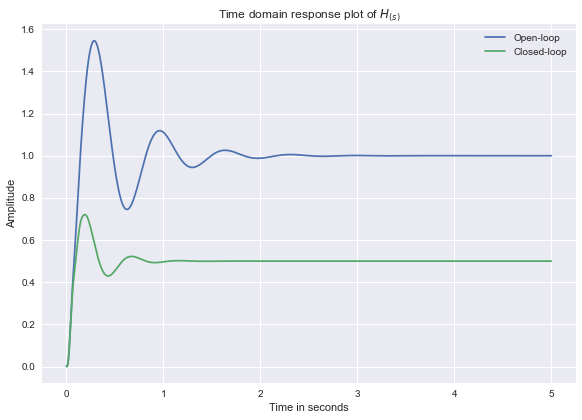

In [5]:
# Use sample time array for the visualization which consists of about 2250 sample points in time

t = np.arange(0,5,1e-3)

# Plot the open & closed systems

systems = [H_op,H_cl]
for x in systems:
    [t,y] = control.step_response(x,t)
    plt.style.use('seaborn'); plt.grid()
    plt.plot(t,y)
    
plt.tight_layout()
plt.title(r'Time domain response plot of $H_{(s)}$', fontsize = 'large')
plt.legend(["Open-loop",'Closed-loop'])
plt.xlabel('Time in seconds'); plt.ylabel('Amplitude')
plt.show()

In control theory, additional Gain is cascaded with the system to tune the transient performance. We can see the effect of different gains on the open-loop model (original TF) and see the response times of the MSD model. We observe that larger the gain, higher the steady state error of the MSD model

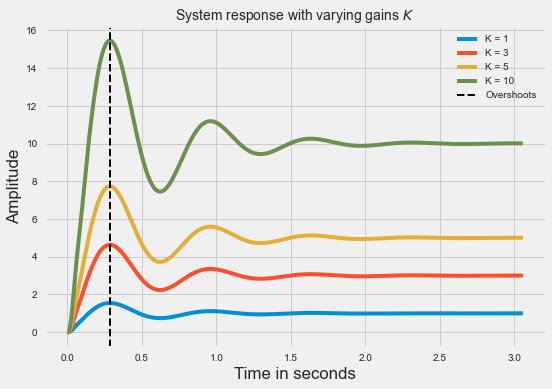

In [6]:
# Create the gain vcector with increasing values

Gain = np.array([1,3,5,10])

for K in Gain:
    num_gain = num * K
    H_gain = control.tf(num_gain,den)
    [t_gain,y_gain] = control.step_response(H_gain)
    plt.style.use('fivethirtyeight'); plt.grid()
    plt.plot(t_gain,y_gain,label = 'K = ' + str(K))
        
plt.title(r'System response with varying gains $K$', fontsize='medium')
plt.xlabel('Time in seconds'); plt.ylabel('Amplitude')
plt.axvline(t_gain[np.argmax(y_gain)], color = 'black', label = 'Overshoots',
            linestyle = '--', linewidth = 2)
plt.legend()
plt.show()

Additonally, every control system has a time constant $\tau$ whose impact can be assessed based on an input signal. Before that, it is useful to check the poles and zeros of the system for stability criteria. This can be done with the Python code below:

In [7]:
# Extract the pole and zeros of the open-loop TF

z = control.zero(H_op)
print('System zero(s): ', z)
print()
p =  control.pole(H_op)
print('System pole(s): ', p)

System zero(s):  [-18.08333333]

System pole(s):  [-21.30380809+80.56972572j -21.30380809-80.56972572j
  -2.25997644 +9.31811091j  -2.25997644 -9.31811091j]


We see that the denominator roots (poles) are complex conjugates i.e. have a real and imaginary part as polar opposites. This means the system is stable only marginally as 2 poles almost lie on the imaginary axis and have real parts close to zero. Since all of them lie on the left hand of the s-plane, the open-loop system can be seen as a stable one. This can be visualized on a pole-zero map as shown below:

<Figure size 72x396 with 0 Axes>

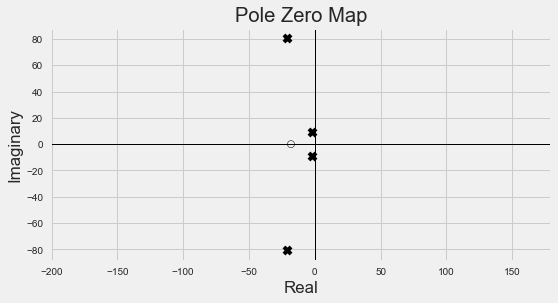

In [8]:
# Launch the pole-zero map for the open-loop system

plt.figure().set_figwidth(1)
plt.figure().set_figheight(4)
control.pzmap(H_op)
plt.show()

In real-life, step inputs are not instant and have a time delay, which can be expressed as $𝑒^{\tau s}$. In Python, we can use a technique called $'Padé Approximation'$ which can be used for the time delay and can be convoluded with the existing model to visualize its impact on the transient characteristics

H(Padé) =  
-s^5 + 10 s^4 - 46.67 s^3 + 124.4 s^2 - 186.7 s + 124.4
-------------------------------------------------------
s^5 + 10 s^4 + 46.67 s^3 + 124.4 s^2 + 186.7 s + 124.4




<Figure size 72x396 with 0 Axes>

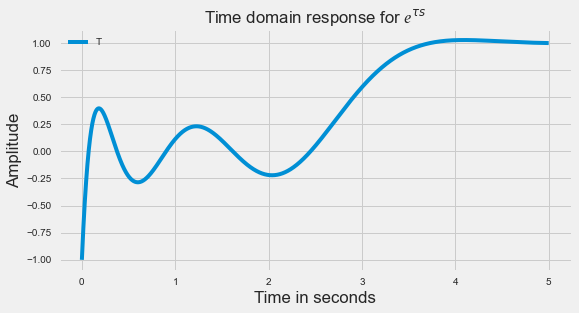

In [9]:
# Time delay and approximation order

Tau = 3
N = 5

[num_p, den_p] =  control.pade(Tau,N)
H_p = control.tf(num_p, den_p)
print('H(Padé) = ', H_p)
print()
[t_p, y_p] = control.step_response(H_p,t)

plt.figure().set_figwidth(1)
plt.figure().set_figheight(4)
plt.plot(t_p,y_p)
plt.tight_layout()
plt.title(r'Time domain response for $𝑒^{\tau s}$', fontsize = 'large')
plt.legend("Time-delay", loc = 'best')
plt.xlabel('Time in seconds'); plt.ylabel('Amplitude')
plt.show()

We can now cascade this with the open-loop response to visualize system transient response with a time delay for a more realistic consideration

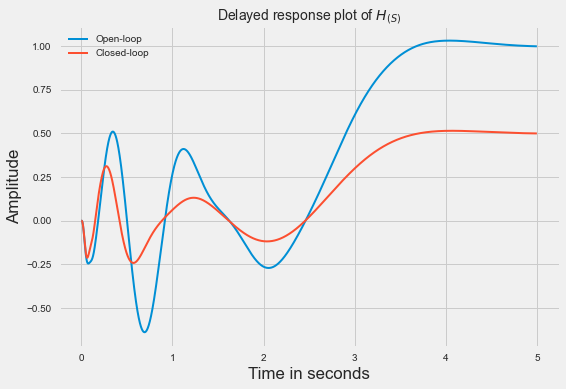

In [10]:
for x in systems:
    H_delay = control.series(H_p,x)
    [t_delay, y_delay] = control.step_response(H_delay,t)
    plt.plot(t_delay,y_delay, linewidth = 2)

plt.title('Delayed response plot of $H_{(S)}$', fontsize='medium')
plt.xlabel('Time in seconds'); plt.ylabel('Amplitude')
plt.legend(['Open-loop', 'Closed-loop'])
plt.show()

We can now proceed with the most common method used to control a system, the PID controller. For this tutorial, we focus on using the proportional gain $K_p$, time integral $T_i$ and the time derivative $T_d$. NOTE: These numbers were chosen without design considerations and were tuned for the purpose of demonstration

In [11]:
# Use the PI control for improving open-loop response

H_op_delay = control.series(H_p,H_op)

# PID controller parameters

Kp = 0.40
Ti = 1.60
Td = 0.10

display(Math('Proportional \ gain,\ K_p = {}'.format(Kp)))
display(Math('Time \ integral,\ T_i = {}'.format(Ti)))
display(Math('Time \ derivative,\ T_d = {}'.format(Td)))
display(Math('Reference \ PID \ control \ equation = K_p \ (K_pT_iT_d{s^2} + T_is + 1) \ / \ T_is'))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [12]:
# Setup the PID transfer function required for cascade

num_pi = np.array([Kp*Ti*Td, Kp*Ti, Kp])
den_pi = np.array([Ti, 0])
H_pi = control.tf(num_pi,den_pi)
print()
print('PID block after computation = ')
print(H_pi)


PID block after computation = 

0.064 s^2 + 0.64 s + 0.4
------------------------
         1.6 s



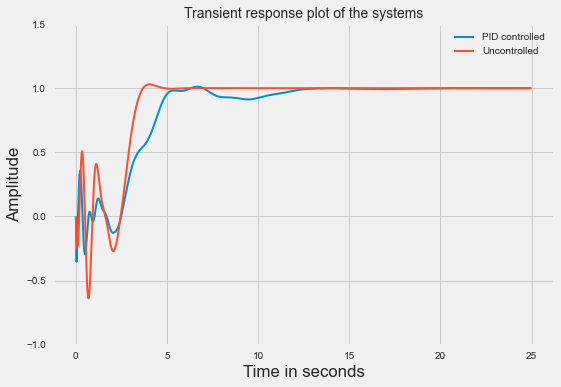

In [13]:
# Finalize the cascade system (PI and open-loop with delay) and visualize the plot response

H_final = control.series(H_pi,H_op_delay)

# Give this block a unity feedback loop before visualizing its step response

H_feed = control.feedback(H_final,1)
[t_pi,y_pi] = control.step_response(H_feed)

# Plot the result and compare with uncontrolled open-loop delay response

compare_sys = [H_feed,H_op_delay]
t_new = np.arange(0,25,0.01)

for x in compare_sys:
    [t_comp, y_comp] = control.step_response(x,t_new)
    plt.style.use('fivethirtyeight'); plt.grid()
    plt.plot(t_comp,y_comp, linewidth = 2)

plt.legend(['PID controlled','Uncontrolled'], loc = 'best')
plt.title('Transient response plot of the systems', fontsize='medium')
plt.xlabel('Time in seconds'); plt.ylabel('Amplitude')
plt.ylim(-1,1.5)
plt.show()

We can see that the PID controller was effective in eliminating the overshoot and initial oscillations caused by the time delay $\tau$. However, this came at the cost of increased settling time and slow response. The designer can choose the balancing of the trade-offs when designing the parameters of the PID controller. To investigate the stability even further, we can use the bode method as shown below: 

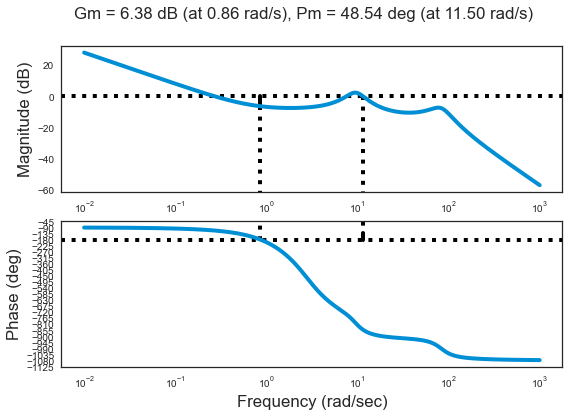

In [14]:
# Bode Diagram with Stability Margins

plt.style.use('seaborn-white')
control.bode(H_final, dB = True, deg = True, margins = True)
plt.show()

We can see from the bode plot that the effect of proportional gain $K_p$ is very significant for this system. Even a small inccrease can cause the steady-state error to increase. While PID is used in many cases, other controllers such as the LQR can be quite effective especially when systems are subjected to time delay or noises. This marks the end of the tutorial. Hope the student viewing this found it useful! Thank you for viewing this repository. Goodluck in your future endeavors :)

Additional resources: 

Python control tutorials: https://www.halvorsen.blog/documents/programming/python/resources/powerpoints/Control%20System%20with%20Python%20-%20Air%20Heater%20System.pdf